<a href="https://colab.research.google.com/github/apurvakumbhar/Computer_vision/blob/main/Exp05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


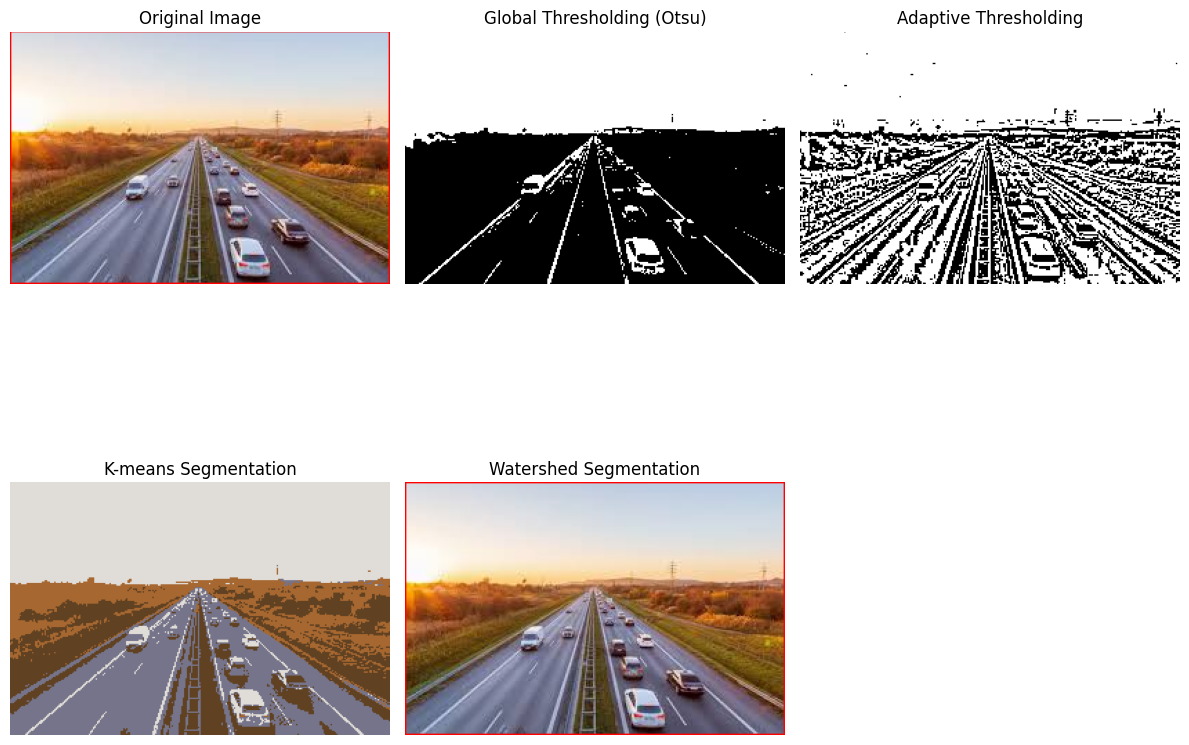

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image = cv2.imread('/content/drive/MyDrive/CV/road.jpg')

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# ----- 1. Global Thresholding (Otsu's Method) -----
# Otsu's method automatically computes an optimal threshold
ret, global_thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# ----- 2. Adaptive Thresholding -----
# Adaptive thresholding allows different regions to have different thresholds
adaptive_thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                       cv2.THRESH_BINARY, 11, 2)

# ----- 3. K-means Clustering for Image Segmentation -----
# Reshape the image into a 2D array of pixels (each row is a pixel, and columns are color channels)
Z = image.reshape((-1, 3))
Z = np.float32(Z)

# Define criteria and apply kmeans()
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
k = 4  # Number of clusters
_, labels, centers = cv2.kmeans(Z, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

# Convert back to 8 bit values
centers = np.uint8(centers)
segmented_image = centers[labels.flatten()]

# Reshape back to the original image dimensions
segmented_image = segmented_image.reshape(image.shape)

# ----- 4. Watershed Algorithm -----
# First, we need to prepare the image by applying morphological operations
# Convert the image to grayscale and apply GaussianBlur
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Use Canny edge detection to find edges
edges = cv2.Canny(blurred, 50, 150)

# Find contours and create a mask
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
mask = np.zeros_like(gray)

# Draw contours on the mask
cv2.drawContours(mask, contours, -1, (255), thickness=cv2.FILLED)

# Use the mask to find markers for watershed algorithm
# The markers array needs to be a 32-bit integer type
# Generate markers for the watershed algorithm
ret, markers = cv2.connectedComponents(mask)

# Add one to all labels so that background is 1, not 0
markers = markers + 1

# Mark the foreground objects with a value greater than 1
markers[mask == 255] = 2


# Apply watershed
cv2.watershed(image, markers)
image[markers == -1] = [0, 0, 255]  # Mark boundaries with red

# ----- 5. Visualize and Compare Results -----
plt.figure(figsize=(12, 10))

# Original Image
plt.subplot(2, 3, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis('off')

# Global Thresholding (Otsu's Method)
plt.subplot(2, 3, 2)
plt.imshow(global_thresh, cmap='gray')
plt.title("Global Thresholding (Otsu)")
plt.axis('off')

# Adaptive Thresholding
plt.subplot(2, 3, 3)
plt.imshow(adaptive_thresh, cmap='gray')
plt.title("Adaptive Thresholding")
plt.axis('off')

# K-means Segmentation
plt.subplot(2, 3, 4)
plt.imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB))
plt.title("K-means Segmentation")
plt.axis('off')

# Watershed Segmentation
plt.subplot(2, 3, 5)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Watershed Segmentation")
plt.axis('off')

plt.tight_layout()
plt.show()